# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.16.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
fatal: destination path 'BLIP' already exists and is not an empty directory.
/content/BLIP


In [ ]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

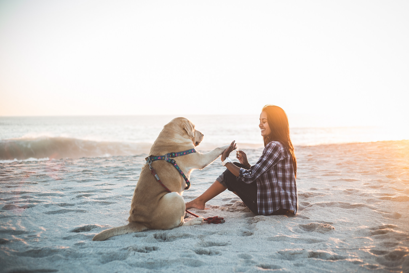

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.97G/1.97G [00:08<00:00, 244MB/s]


reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a woman and her dog on the beach


In [ ]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
    print('caption: '+caption[0])

# VQA
Perform visual question answering using finetuned BLIP model

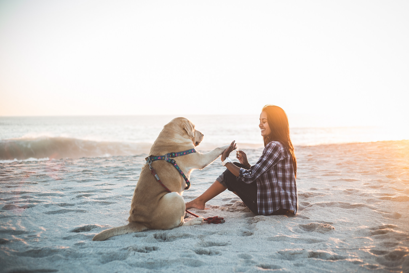

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth
answer: on beach


In [ ]:
from models.blip_vqa import blip_vqa

image_size = 480
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'

model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

question = 'where is the woman sitting?'

with torch.no_grad():
    answer = model(image, question, train=False, inference='generate')
    print('answer: '+answer[0])

# Feature Extraction

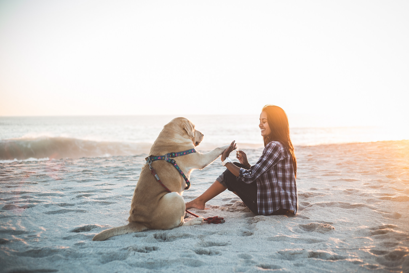

100%|██████████| 1.97G/1.97G [01:45<00:00, 20.1MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [ ]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'

model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

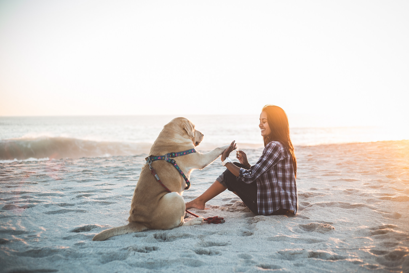

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: a woman sitting on the beach with a dog
The image and text is matched with a probability of 0.9960
The image feature and text feature has a cosine similarity of 0.5262


In [ ]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cuda')

caption = 'a woman sitting on the beach with a dog'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

# ドライブをマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.16.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

# prompt: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market1501/0001_c1s1_001051_00.jpg
# ここから画像を拾ってきたいです
from PIL import Image
from models.blip import blip_decoder
import numpy as np
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device,raw_image):
#    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
#    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
    raw_image = raw_image

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

!cp /content/drive/MyDrive/ISAS/Meeting/Fujitsu/blip_vqa_3.py /content/BLIP/models/
from models.blip_vqa_3 import blip_vqa
image_size = 480
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
model_vqa = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model_vqa.eval()
model_vqa = model_vqa.to(device)


Mounted at /content/drive
Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 20.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.5 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292833 sha256=378b23051aaa4e72f4cad2d36e88434c3f5e7f32cbc30d54571235506316d205
  Stored in directory: /root/.cache/pip/wheels/08/58/6f/56c57fa8315eb0bcf0287b580c850845be5f116359b809e9f1
Successfully built fairscale
  Attempting uninstall: transformers
    Found existing installation: transformers 

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.35G/1.35G [01:17<00:00, 18.7MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


KaggleからデータをGoogle Driveに保存、保存したデータをGoogle Colabで参照する

In [ ]:
# Kaggleからデータセットをダウンロード
!kaggle datasets download -d pengcw1/market-1501

# Google Driveの任意のフォルダに保存する
!unzip market-1501.zip -d /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501

# # Google DriveのMarket-1501データセットを参照
# query_dir = "/content/drive/MyDrive/Market-1501/Market-1501-v15.09.15/query/"

# # ファイルリストを取得して画像を表示
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# query_images = os.listdir(query_dir)
# img_path = os.path.join(query_dir, query_images[0])
# img = Image.open(img_path)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# キャプション＋VQA＋評価のモデル読み込み

In [2]:
# prompt: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market1501/0001_c1s1_001051_00.jpg
# ここから画像を拾ってきたいです
from PIL import Image
from models.blip import blip_decoder
import numpy as np
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def load_demo_image(image_size,device,raw_image):
# #    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
# #    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
#     raw_image = raw_image

#     w,h = raw_image.size
#     display(raw_image.resize((w//5,h//5)))

#     transform = transforms.Compose([
#         transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
#         transforms.ToTensor(),
#         transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#         ])
#     image = transform(raw_image).unsqueeze(0).to(device)
#     return image


# #Caption
# image_size = 384
# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
# model_caption = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
# model_caption.eval()
# model_caption = model_caption.to(device)

# #VQA
# !cp /content/drive/MyDrive/ISAS/Meeting/Fujitsu/blip_vqa_2.py /content/BLIP/models/
# from models.blip_vqa_2 import blip_vqa
# image_size = 480
# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
# model_vqa = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
# model_vqa.eval()
# model_vqa = model_vqa.to(device)


# #eval
# # prompt: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/blip_itm_2.pyを
# # /content/BLIP/modelsの直下にコピーしたい
# !cp /content/drive/MyDrive/ISAS/Meeting/Fujitsu/blip_itm_2.py /content/BLIP/models/
# from models.blip_itm_2 import blip_itm

# image_size = 384
# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

# model_eval = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
# model_eval.eval()
# model_eval = model_eval.to(device='cuda')


!cp /content/drive/MyDrive/ISAS/Meeting/Fujitsu/blip_feat_extract.py /content/BLIP/models/
from models.blip_feat_extract import blip_feat_extract

image_size = 384
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

model_feat = blip_feat_extract(pretrained=model_url, image_size=image_size, vit='base')
model_feat.eval()
model_feat = model_feat.to(device='cuda')

100%|██████████| 1.78G/1.78G [01:34<00:00, 20.2MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


# マッチング評価_test

question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?
The original image


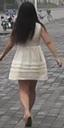

a woman walking down the street

Q1. male?:  no man
Q2. female?:  girl
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  sleeveless
Q9. type of bottoms?:  skirt
Q10. type of shoes?:  flats
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  black
Q14. type of bag?:  shoulder bag
Q15. color of bag?:  black


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


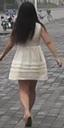

caption: a woman walking down the street
Q1. male?:  no man
Q2. female?:  girl
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  sleeveless
Q9. type of bottoms?:  skirt
Q10. type of shoes?:  flats
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  black
Q14. type of bag?:  shoulder bag
Q15. color of bag?:  black
This picture has a cosine similarity of 1.0000


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


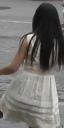

caption: a little girl playing in the water
Q1. male?:  no
Q2. female?:  girl
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  tank tops
Q9. type of bottoms?:  skirt
Q10. type of shoes?:  Not confident
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  black
Q14. type of bag?:  Not confident
Q15. color of bag?:  black
This picture has a cosine similarity of 0.7829


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


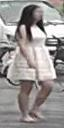

caption: a woman walking down the street
Q1. male?:  no man
Q2. female?:  girl
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  sleeveless
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  Not confident
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  white
Q14. type of bag?:  purse
Q15. color of bag?:  white
This picture has a cosine similarity of 0.9059


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


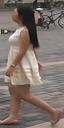

caption: a woman walking down the street
Q1. male?:  no
Q2. female?:  woman
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  sleeveless
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  Not confident
Q11. color of tops?:  white
Q12. color of bottoms?:  tan
Q13. color of shoes?:  white
Q14. type of bag?:  purse
Q15. color of bag?:  black
This picture has a cosine similarity of 0.8248


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


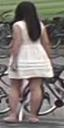

caption: a woman riding a bike
Q1. male?:  no
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  sleeveless
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  Not confident
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  white
Q14. type of bag?:  purse
Q15. color of bag?:  black
This picture has a cosine similarity of 0.8297


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


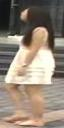

caption: a woman dancing on a stage
Q1. male?:  yes
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  tank tops
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  Not confident
Q11. color of tops?:  white
Q12. color of bottoms?:  white
Q13. color of shoes?:  white
Q14. type of bag?:  Not confident
Q15. color of bag?:  black
This picture has a cosine similarity of 0.6892


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


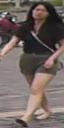

caption: a woman dancing in the street
Q1. male?:  no
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  Not confident
Q11. color of tops?:  black
Q12. color of bottoms?:  brown
Q13. color of shoes?:  black
Q14. type of bag?:  shoulder bag
Q15. color of bag?:  red
This picture has a cosine similarity of 0.7364


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


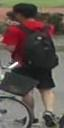

caption: a man riding a bike
Q1. male?:  yes
Q2. female?:  no
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  tennis shoes
Q11. color of tops?:  red
Q12. color of bottoms?:  black
Q13. color of shoes?:  black
Q14. type of bag?:  backpack
Q15. color of bag?:  black
This picture has a cosine similarity of 0.6906


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


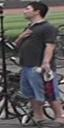

caption: a man riding a bike
Q1. male?:  yes
Q2. female?:  no woman
Q3. color of skin?:  white
Q4. color of hair?:  brown
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  jeans
Q10. type of shoes?:  Not confident
Q11. color of tops?:  black
Q12. color of bottoms?:  blue
Q13. color of shoes?:  white
Q14. type of bag?:  backpack
Q15. color of bag?:  black
This picture has a cosine similarity of 0.6763


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


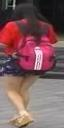

caption: a woman in a red dress
Q1. male?:  no
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  blonde
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  pants
Q10. type of shoes?:  Not confident
Q11. color of tops?:  red
Q12. color of bottoms?:  tan
Q13. color of shoes?:  brown
Q14. type of bag?:  Not confident
Q15. color of bag?:  pink
This picture has a cosine similarity of 0.5301


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


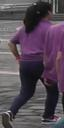

caption: two people walking down a street
Q1. male?:  no
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  long
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  pants
Q10. type of shoes?:  sneakers
Q11. color of tops?:  purple
Q12. color of bottoms?:  blue
Q13. color of shoes?:  white
Q14. type of bag?:  Not confident
Q15. color of bag?:  blue
This picture has a cosine similarity of 0.5918


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


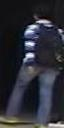

caption: a man playing a guitar
Q1. male?:  yes
Q2. female?:  yes
Q3. color of skin?:  white
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  pants
Q10. type of shoes?:  tennis shoes
Q11. color of tops?:  black
Q12. color of bottoms?:  blue
Q13. color of shoes?:  black
Q14. type of bag?:  backpack
Q15. color of bag?:  blue
This picture has a cosine similarity of 0.6477


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


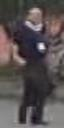

caption: a man in a police uniform
Q1. male?:  yes
Q2. female?:  no
Q3. color of skin?:  white
Q4. color of hair?:  brown
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  sweaters
Q9. type of bottoms?:  pants
Q10. type of shoes?:  sneakers
Q11. color of tops?:  black
Q12. color of bottoms?:  black
Q13. color of shoes?:  black
Q14. type of bag?:  backpack
Q15. color of bag?:  black
This picture has a cosine similarity of 0.6419


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


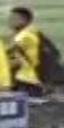

caption: a man sitting on a bench
Q1. male?:  yes
Q2. female?:  no woman
Q3. color of skin?:  black
Q4. color of hair?:  black
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  Not confident
Q9. type of bottoms?:  pants
Q10. type of shoes?:  tennis shoes
Q11. color of tops?:  yellow
Q12. color of bottoms?:  black
Q13. color of shoes?:  black
Q14. type of bag?:  Not confident
Q15. color of bag?:  yellow
This picture has a cosine similarity of 0.5970


question: male?
question: female?
question: color of skin?
question: color of hair?
question: young or middle or old? how confident?
question: Fat or skinny?
question: length of hair?
question: type of tops?
question: type of bottoms?
question: type of shoes?
question: color of tops?
question: color of bottoms?
question: color of shoes?
question: type of bag?
question: color of bag?


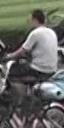

caption: a person on a motorcycle
Q1. male?:  yes
Q2. female?:  no woman
Q3. color of skin?:  white
Q4. color of hair?:  brown
Q5. young or middle or old? how confident?:  young
Q6. Fat or skinny?:  skinny
Q7. length of hair?:  short
Q8. type of tops?:  t shirts
Q9. type of bottoms?:  shorts
Q10. type of shoes?:  tennis shoes
Q11. color of tops?:  white
Q12. color of bottoms?:  black
Q13. color of shoes?:  black
Q14. type of bag?:  backpack
Q15. color of bag?:  black
This picture has a cosine similarity of 0.7087
[['0001_c1s1_001051_00.jpg']
 ['0001_c2s1_000301_00.jpg']
 ['0001_c3s1_000551_00.jpg']
 ['0001_c4s6_000810_00.jpg']
 ['0001_c5s1_001426_00.jpg']
 ['0001_c6s1_009601_00.jpg']
 ['0003_c4s6_015641_00.jpg']
 ['0004_c2s3_059152_00.jpg']
 ['0005_c5s1_000401_00.jpg']
 ['0019_c6s4_002427_00.jpg']
 ['0024_c1s1_002326_00.jpg']
 ['0041_c6s3_087667_00.jpg']
 ['0054_c2s1_005701_00.jpg']
 ['0071_c3s1_010501_00.jpg']
 ['0078_c5s1_011576_00.jpg']]
[[0.99999994]
 [0.78290248]
 [0.90590322]
 [0

In [3]:
import os
from PIL import Image

##data input
#もととなる画像
origin_path = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market1501_test/0001_c1s1_001051_00.jpg'
# 画像ファイルのパスを格納するリスト
image_paths = []
# 画像ファイルのディレクトリ
image_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market1501_test/'
# ディレクトリ内のファイル一覧を取得
filenames = [filename for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]
# ファイル名をアルファベット順にソート
filenames.sort()
# ディレクトリ内のファイル一覧を取得
for filename in filenames:
  # ファイルが画像ファイル（.jpg, .pngなど）の場合
  if filename.endswith(('.jpg', '.png', '.jpeg')):
    # 画像ファイルのパスをリストに追加
    image_paths.append(os.path.join(image_dir, filename))


question = []
answers = [] # Change the answer variable to a list

question.append('male?')
question.append('female?')
question.append('color of skin?')
question.append('color of hair?')
question.append('young or middle or old? how confident?')
question.append('Fat or skinny?')
question.append('length of hair?')
question.append('type of tops?')
question.append('type of bottoms?')
question.append('type of shoes?')
question.append('color of tops?')
question.append('color of bottoms?')
question.append('color of shoes?')
question.append('type of bag?')
question.append('color of bag?')
# question.append('Please tell me the sex, coleor of the cloth, color of the skin.')
# question.append('discribe the person in detail as much as possible.')
# question.append('please make a caption')

raw_image_origin = Image.open(origin_path).convert('RGB')
raw_image = []
image_size_cap = 384
image_cap_origin = load_demo_image(image_size=image_size_cap,device=device,raw_image=raw_image_origin)
image_cap = []
image_size_vqa = 480
image_vqa_origin = load_demo_image(image_size=image_size_vqa,device=device,raw_image=raw_image_origin)
image_vqa = []
explanations_origin = ''
explanations = []
explanation = ''
answers_origin = []
answer = []

num_beams = 5
T = 50000
confidence_threshold = 0.35

caption_origin = model_caption.generate(image_cap_origin, sample=False, num_beams=3, max_length=20, min_length=5)
explanations_origin = caption_origin[0] + '\n'
answer_ex = ' '
for i in np.arange(len(question)):
      answer.append(model_vqa(image_vqa_origin, question[i], train=False, inference='generate', num_beams=num_beams, confidence_threshold=confidence_threshold,T=T) )
      explanation = explanation + '\nQ'+str(i+1)+ '. ' + question[i] +':  ' + answer[i][0]
      answer_ex = answer_ex + answer[i][0]+', '
answers_origin.append(answer_ex)
explanations_origin = explanations_origin + explanation
print('The original image')
display(raw_image_origin)
print(explanations_origin)

sim = []

# for j in np.arange(0):
for j in np.arange(len(image_paths)):
  raw_image.append(Image.open(image_paths[j]).convert('RGB'))
  image_cap.append(load_demo_image(image_size=image_size_cap,device=device,raw_image=raw_image[j]))
  image_vqa.append(load_demo_image(image_size=image_size_vqa,device=device,raw_image=raw_image[j]))
  # display(raw_image[j])
  answer = [] # Change the answer variable to a list

  with torch.no_grad():
      # beam search
      caption = model_caption.generate(image_cap[j], sample=False, num_beams=3, max_length=20, min_length=5)

  explanation = 'caption: '+caption[0]
  answer_ex = ' '
  with torch.no_grad():
     for i in np.arange(len(question)):
      answer.append(model_vqa(image_vqa[j], question[i], train=False, inference='generate', num_beams=num_beams, confidence_threshold=confidence_threshold,T=T) )
      explanation = explanation + '\nQ'+str(i+1)+ '. ' + question[i] +':  ' + answer[i][0]
      answer_ex = answer_ex + answer[i][0]+', '
  explanations.append(explanation)
  answers.append(answer_ex)
  itc_score = model_eval(answers_origin,answers,match_head='itc')
  sim_j = itc_score[0][j].item()
  sim.append(sim_j)
  display(raw_image[j])
  print(explanation)
  print('This picture has a cosine similarity of %.4f'%sim_j)

sim_t = np.array([sim]).transpose()
filenames_t = np.array([filenames]).transpose()
print(filenames_t)
print(sim_t)

# VQA実行、cos_sim配列取得

In [ ]:
#VQA

num_beams = 5
T = 50000
confidence_threshold = 0.35

import os
from PIL import Image

question = []
question.append('male?')
question.append('female?')
question.append('color of skin?')
question.append('color of hair?')
question.append('young or middle or old? how confident?')
question.append('Fat or skinny?')
question.append('length of hair?')
question.append('type of tops?')
question.append('type of bottoms?')
question.append('type of shoes?')
question.append('color of tops?')
question.append('color of bottoms?')
question.append('color of shoes?')
question.append('type of bag?')
question.append('color of bag?')
# question.append('Please tell me the sex, coleor of the cloth, color of the skin.')
# question.append('discribe the person in detail as much as possible.')
# question.append('please make a caption')

#  画像ファイルのパスを格納するリスト
image_paths = []
# 画像ファイルのディレクトリ
image_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market1501_test/'
# ディレクトリ内のファイル一覧を取得
filenames = [filename for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]
# ファイル名をアルファベット順にソート
filenames.sort()
# ディレクトリ内のファイル一覧を取得
for filename in filenames:
  # ファイルが画像ファイル（.jpg, .pngなど）の場合
  if filename.endswith(('.jpg', '.png', '.jpeg')):
    # 画像ファイルのパスをリストに追加
    image_paths.append(os.path.join(image_dir, filename))


image_size_vqa = 480
raw_image = []
image_vqa = []
answers = [] # Change the answer variable to a list
answer = []
sim = []
sim_all = []


for l in np.arange(len(image_paths)):
  raw_image.append(Image.open(image_paths[l]).convert('RGB'))
  image_vqa.append(load_demo_image(image_size=image_size_vqa,device=device,raw_image=raw_image[l]))

for k in np.arange(3):
# for k in np.arange(len(image_paths)):
  answer = [] # Change the answer variable to a list
  sim = []
  answers_query = ' '
  for i in np.arange(len(question)):
        answer.append(model_vqa(image_vqa[k], question[i], train=False, inference='generate', num_beams=num_beams, confidence_threshold=confidence_threshold,T=T) )
        answers_query = answers_query + answer[i][0]+', '
  for j in np.arange(3):
  # for j in np.arange(len(image_paths)):
    # display(raw_image[j])
    answer = [] # Change the answer variable to a list
    answer_ex = ' '
    with torch.no_grad():
      for i in np.arange(len(question)):
        answer.append(model_vqa(image_vqa[j], question[i], train=False, inference='generate', num_beams=num_beams, confidence_threshold=confidence_threshold,T=T) )
        answer_ex = answer_ex + answer[i][0]+', '
      itc_score = model_eval(answers_query,answer_ex,match_head='itc')
    sim.append(itc_score[0].item())
  sim_all.append(sim)
  # print('This picture has a cosine similarity of %.4f'%sim_j)
print(sim_all)
# cosine_similaritiesはクエリとギャラリーのコサイン類似度の2次元配列（NumPy配列形式）
np.fill_diagonal(sim_all, 0)  # 対角成分を0にする


[[0.9999998807907104, 0.7829024791717529, 0.9059032201766968], [0.7829024791717529, 1.000000238418579, 0.7944298982620239], [0.9059032201766968, 0.7944298982620239, 1.0]]


In [ ]:
query_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query'


# ディレクトリ内のファイル一覧を取得
filenames = [filename for filename in os.listdir(query_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]
# ファイル名をアルファベット順にソート
filenames.sort()
print(query_dir)

filenames = filenames[0:4]
print(filenames)

/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query
['0001_c1s1_001051_00.jpg', '0001_c2s1_000301_00.jpg', '0001_c3s1_000551_00.jpg', '0001_c4s6_000810_00.jpg']


# Rank-1、mAP取得

## データセット作成、id等抽出

In [3]:
from torch.utils.data import DataLoader, Dataset # Datasetクラスをインポート
import os
from PIL import Image
import numpy as np

query_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query'
gallery_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test'


# カスタムデータセットの作成
# encoding: utf-8
"""
@author:  sherlock
@contact: sherlockliao01@gmail.com
"""

import glob
import re

import os.path as osp

from collections import defaultdict
import pickle


class BaseDataset(object):
    """
    Base class of reid dataset
    """

    def get_imagedata_info(self, data):
        pids, cams, tracks = [], [], []
        for _, pid, camid, trackid in data:
            pids += [pid]
            cams += [camid]
            tracks += [trackid]
        pids = set(pids)
        cams = set(cams)
        tracks = set(tracks)
        num_pids = len(pids)
        num_cams = len(cams)
        num_imgs = len(data)
        num_views = len(tracks)
        return num_pids, num_imgs, num_cams, num_views

    def print_dataset_statistics(self):
        raise NotImplementedError


class BaseImageDataset(BaseDataset):
    """
    Base class of image reid dataset
    """

    def print_dataset_statistics(self, train, query, gallery):
        num_train_pids, num_train_imgs, num_train_cams, num_train_views = self.get_imagedata_info(train)
        num_query_pids, num_query_imgs, num_query_cams, num_train_views = self.get_imagedata_info(query)
        num_gallery_pids, num_gallery_imgs, num_gallery_cams, num_train_views = self.get_imagedata_info(gallery)

        print("Dataset statistics:")
        print("  ----------------------------------------")
        print("  subset   | # ids | # images | # cameras")
        print("  ----------------------------------------")
        print("  train    | {:5d} | {:8d} | {:9d}".format(num_train_pids, num_train_imgs, num_train_cams))
        print("  query    | {:5d} | {:8d} | {:9d}".format(num_query_pids, num_query_imgs, num_query_cams))
        print("  gallery  | {:5d} | {:8d} | {:9d}".format(num_gallery_pids, num_gallery_imgs, num_gallery_cams))
        print("  ----------------------------------------")



class Market1501(BaseImageDataset):
    """
    Market1501
    Reference:
    Zheng et al. Scalable Person Re-identification: A Benchmark. ICCV 2015.
    URL: http://www.liangzheng.org/Project/project_reid.html

    Dataset statistics:
    # identities: 1501 (+1 for background)
    # images: 12936 (train) + 3368 (query) + 15913 (gallery)
    """
    dataset_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15'
    #dataset_dir = 'Market'

    def __init__(self, root='', verbose=True, pid_begin = 0, **kwargs):
        super(Market1501, self).__init__()
        self.dataset_dir = osp.join(root, self.dataset_dir)
        self.train_dir = osp.join(self.dataset_dir, 'bounding_box_train')
        self.query_dir = osp.join(self.dataset_dir, 'query')
        self.gallery_dir = osp.join(self.dataset_dir, 'bounding_box_test')

        self._check_before_run()
        self.pid_begin = pid_begin
        train = self._process_dir(self.train_dir, relabel=True)
        query = self._process_dir(self.query_dir, relabel=False)
        gallery = self._process_dir(self.gallery_dir, relabel=False)

        if verbose:
            print("=> Market1501 loaded")
            self.print_dataset_statistics(train, query, gallery)

        self.train = train
        self.query = query
        self.gallery = gallery

        self.num_train_pids, self.num_train_imgs, self.num_train_cams, self.num_train_vids = self.get_imagedata_info(self.train)
        self.num_query_pids, self.num_query_imgs, self.num_query_cams, self.num_query_vids = self.get_imagedata_info(self.query)
        self.num_gallery_pids, self.num_gallery_imgs, self.num_gallery_cams, self.num_gallery_vids = self.get_imagedata_info(self.gallery)

    def _check_before_run(self):
        """Check if all files are available before going deeper"""
        if not osp.exists(self.dataset_dir):
            raise RuntimeError("'{}' is not available".format(self.dataset_dir))
        if not osp.exists(self.train_dir):
            raise RuntimeError("'{}' is not available".format(self.train_dir))
        if not osp.exists(self.query_dir):
            raise RuntimeError("'{}' is not available".format(self.query_dir))
        if not osp.exists(self.gallery_dir):
            raise RuntimeError("'{}' is not available".format(self.gallery_dir))

    def _process_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')

        pid_container = set()
        for img_path in sorted(img_paths):
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            pid_container.add(pid)
        pid2label = {pid: label for label, pid in enumerate(pid_container)}
        dataset = []
        for img_path in sorted(img_paths):
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            assert 0 <= pid <= 1501  # pid == 0 means background
            assert 1 <= camid <= 6
            camid -= 1  # index starts from 0
            if relabel: pid = pid2label[pid]

            dataset.append((img_path, self.pid_begin + pid, camid, 0))
        return dataset
# データのトランスフォーム（例: リサイズ、テンソル化）
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor()
])
query_dir = '/content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query'
# データセットの作成（query ディレクトリを使用）
query_dataset = Market1501(image_dir=query_dir, transform=transform)
gallery_dataset = Market1501(image_dir=gallery_dir, transform=transform)
# # クエリとギャラリーのデータセットを結合
# full_dataset = torch.utils.data.ConcatDataset([query_dataset, gallery_dataset])
# # DataLoaderの作成
# val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, num_workers=4)

# クエリ画像の数を取得（query ディレクトリの画像数）
# num_query = len(query_dataset)

=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------


In [13]:
# query_datasetの最初の5個のエントリを表示
for i in range(5):
    img_path, pid, camid, _ = query_dataset.query[i]
    print(f"Image Path: {img_path}, Person ID: {pid}, Camera ID: {camid}")


Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query/0001_c1s1_001051_00.jpg, Person ID: 1, Camera ID: 0
Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query/0001_c2s1_000301_00.jpg, Person ID: 1, Camera ID: 1
Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query/0001_c3s1_000551_00.jpg, Person ID: 1, Camera ID: 2
Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query/0001_c4s6_000810_00.jpg, Person ID: 1, Camera ID: 3
Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/query/0001_c5s1_001426_00.jpg, Person ID: 1, Camera ID: 4


In [15]:
# prompt: gallery_datasetから、の最初の5個のエントリを表示したい

for i in range(5):
    img_path, pid, camid, _ = gallery_dataset.gallery[i]
    print(f"Image Path: {img_path}, Person ID: {pid}, Camera ID: {camid}")


## answer配列作成

In [9]:
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np

#VQA
num_beams = 3
T = 50000
confidence_threshold = 0.35
# query_num = 100

question = []
question.append('male or female?')
question.append('color of skin?')
question.append('color of hair?')
# question.append('young or middle or old? how confident?')
question.append('Fat or skinny?')
question.append('length of hair?')
question.append('type of tops?')
question.append('type of bottoms?')
question.append('type of shoes?')
question.append('color of tops?')
question.append('color of bottoms?')
# question.append('color of shoes?')
# question.append('type of bag?')
# question.append('color of bag?')
# question.append('Please tell me the sex, coleor of the cloth, color of the skin.')
# question.append('discribe the person in detail as much as possible.')
# question.append('please make a caption')

#  画像ファイルのパスを格納するリスト
image_paths = []
# image_paths = [item[0] for item in query_dataset.query]
image_paths = [item[0] for item in gallery_dataset.gallery]

image_size_vqa = 480
raw_image = []
image_vqa = []
answers = [] # Change the answer variable to a list
answer = []
sim = []
sim_all = []


for l in np.arange(len(image_paths)):
  raw_image.append(Image.open(image_paths[l]).convert('RGB'))
  image_vqa.append(load_demo_image(image_size=image_size_vqa,device=device,raw_image=raw_image[l]))

import pandas as pd

answers =[]
start=0
end=3000
#保存先変えるンも忘れずに

for j in range(len(image_paths)):
    if j >= start and j < end:
    # display(raw_image[j])
      answer = [] # Change the answer variable to a list
      answer_ex = ' '
      with torch.no_grad():
        for i in np.arange(len(question)):
          answer.append(model_vqa(image_vqa[j], question[i], train=False, inference='generate', num_beams=num_beams, confidence_threshold=confidence_threshold,T=T) )
          answer_ex = answer_ex + answer[i][0]+', '

      answers.append(answer_ex)
      print(j)


# NumPy配列をPandas DataFrameに変換
df = pd.DataFrame(answers)
# CSVファイルとして保存
# df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/query_answers.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_1.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_2.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_3.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_4.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_5.csv', index=False, header=False)
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers_6.csv', index=False, header=False)

Output hidden; open in https://colab.research.google.com to view.

## 特徴量配列作成

In [10]:
import pandas as pd
# CSVファイルを読み込む
answers_df = pd.read_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/query_answers.csv', header=None)
p_id, c_id, text_feature = answers_df


ValueError: not enough values to unpack (expected 3, got 1)

In [11]:
answers_df

,0
0,"female, white, black, skinny, long, sleeveles..."
1,"female, white, black, skinny, long, tank tops..."
2,"female, white, black, skinny, long, dress, sh..."
3,"female, white, black, skinny, short, sleevele..."
4,"female, white, black, skinny, short, sleevele..."
...,...
3363,"male, white, black, skinny, short, t shirts, ..."
3364,"male, brown, black, skinny, short, t shirts, ..."
3365,"female, white, brown, skinny, long, t shirt, ..."
3366,"female, white, brown, skinny, short, t shirt,..."


In [11]:
import pandas as pd
# CSVファイルを読み込む
answers_df = pd.read_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/query_answers.csv', header=None)
# answers_df = pd.read_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_answers.csv', header=None)
answers = answers_df.values.tolist()
sim = []
sim_all = []
text_feature = []

image_paths = [item[0] for item in gallery_dataset.gallery]

# for k in np.arange(1):
for k in np.arange(len(image_paths)):
  text_feature_pre = model_feat(answers[k],match_head='itc')
  img_path, pid, camid, _ = gallery_dataset.gallery[i]
  print(k,f"Image Path: {img_path}, Person ID: {pid}, Camera ID: {camid}")
  text_feature.append((pid,camid,text_feature_pre[0].tolist()))

# NumPy配列をPandas DataFrameに変換
feature_df = pd.DataFrame(text_feature)
# CSVファイルとして保存
# feature_df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/query_feature.csv', index=False, header=False)
feature_df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/gallery_feature.csv', index=False, header=False)

0 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
1 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
2 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
3 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
4 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
5 Image Path: /content/drive/MyDrive/ISAS/Meeting/Fujitsu/market-1501/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_001376_04.jpg, Person ID: 0, Camera ID: 0
6 Image Path: /content/drive

IndexError: list index out of range

In [ ]:
import pandas as pd
# CSVファイルを読み込む
answers_df = pd.read_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/query_feature.csv', header=None)
answers = answers_df.values.tolist()
print(answers)
p_id,c_id,text_feature = answers_df
print(p_id)
print(c_id)
print(text_feature)

## コサイン類似度計算

In [ ]:
# import pandas as pd
# # CSVファイルを読み込む
# answers_df = pd.read_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/answers.csv', header=None)
# answers = answers_df.values.tolist()
# sim = []
# sim_all = []

# # DataFrameを表示
# for k in np.arange(len(answers)):
#   sim = []
#   # for j in np.arange(4):
#   for j in np.arange(len(answers)):
#       sim.append(np.dot(text_feature[j],text_feature[k]))
#       print(k,j)
#   sim_all.append(sim)
#   # print('This picture has a cosine similarity of %.4f'%sim_j)

# sim_all = np.array(sim_all)
# np.fill_diagonal(sim_all, 0)  # 対角成分を0にする
# print('Cosine similarity : ',sim_all)

# # NumPy配列をPandas DataFrameに変換
# df = pd.DataFrame(sim_all)
# # CSVファイルとして保存
# df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/sim_all.csv', index=False, header=False)

def cosine_similarity(qf, gf):
    epsilon = 0.00001
    dist_mat = qf.mm(gf.t())
    qf_norm = torch.norm(qf, p=2, dim=1, keepdim=True)  # mx1
    gf_norm = torch.norm(gf, p=2, dim=1, keepdim=True)  # nx1
    qg_normdot = qf_norm.mm(gf_norm.t())

    dist_mat = dist_mat.mul(1 / qg_normdot).cpu().numpy()
    dist_mat = 1-np.clip(dist_mat, -1 + epsilon, 1 - epsilon)
    #dist_mat = np.arccos(dist_mat)
    return dist_mat

sim_all = cosine_similarity(text_feature,text_feature)
print('Cosine similarity : ',sim_all)

# NumPy配列をPandas DataFrameに変換
df = pd.DataFrame(sim_all)
# CSVファイルとして保存
df.to_csv('/content/drive/MyDrive/ISAS/Meeting/Fujitsu/sim_all.csv', index=False, header=False)

## Rank1、mAP計算

In [ ]:
# print(f"Number of query images: {num_query}")


def evaluate_rank1_map(val_loader, cosine_similarities, num_query):
    """
    Rank-1 と mAP を計算する関数
    Args:
    - val_loader: 検証データのローダー（画像、人物ID、カメラIDなどを含む）
    - cosine_similarities: クエリとギャラリー画像のコサイン類似度の配列
    - num_query: クエリ画像の数

    Returns:
    - Rank-1 と mAP
    """

    # クエリ画像とギャラリー画像の情報
    query_pids = []
    gallery_pids = []

    # データセットのサイズを取得
    num_total = len(full_dataset)
    num_query = num_total // 2  # クエリとギャラリーを半々に分ける
    print("num_total: ",num_total)
    print("num_query: ",num_query)
    # データローダーを使って、クエリとギャラリーの情報を取得
# データローダーを使って、クエリとギャラリーの情報を取得
    for idx, (imgs, pids, camids, img_paths) in enumerate(val_loader):
        for i in range(len(pids)):
            if len(query_pids) < num_query:
                query_pids.append(pids[i].item())
            else:
                gallery_pids.append(pids[i].item())

    # ギャラリーのデータが正しく読み込まれているか確認
    print("Query PIDs: ", len(query_pids))
    print("Gallery PIDs: ", len(gallery_pids))

    if len(gallery_pids) == 0:
        print("Gallery PIDs are empty. Please check the data loader.")
        return 0, 0

    # Rank-1 と mAP を計算
    correct_rank1 = 0
    average_precisions = []

    for i in range(num_query):
        # クエリiに対するすべてのギャラリー画像との類似度を取得
        similarities = cosine_similarities[i]

        # 類似度をNumPy配列に変換
        similarities = np.array(similarities)
        # 類似度の降順にソートして、ギャラリー画像のインデックスを取得
        sorted_idx = np.argsort(-similarities)
        print(f"Query PID: {query_pids[i]}, Top-1 Gallery PID: {gallery_pids[sorted_idx[0]]}")

        # Rank-1: 最初のギャラリー画像が正解かどうかを確認
        if query_pids[i] == gallery_pids[sorted_idx[0]]:
            correct_rank1 += 1

        # mAP計算のために、平均適合率を計算
        correct_matches = 0
        precision_at_k = []
        for rank, idx in enumerate(sorted_idx):
            if query_pids[i] == gallery_pids[idx]:
                correct_matches += 1
                precision_at_k.append(correct_matches / (rank + 1))

        if correct_matches > 0:
            average_precisions.append(np.mean(precision_at_k))

    # Rank-1とmAPを計算
    rank1 = correct_rank1 / num_query
    mAP = np.mean(average_precisions) if average_precisions else 0.0

    return rank1, mAP


# Rank-1とmAPを計算する
rank1, mAP = evaluate_rank1_map(val_loader, sim_all, num_query)
print(f"Rank-1 Accuracy: {rank1:.2f}, mAP: {mAP:.2f}")


In [ ]:
# encoding: utf-8
"""
@author:  sherlock
@contact: sherlockliao01@gmail.com
"""

import glob
import re

import os.path as osp

from .bases import BaseImageDataset
from collections import defaultdict
import pickle
class Market1501(BaseImageDataset):
    """
    Market1501
    Reference:
    Zheng et al. Scalable Person Re-identification: A Benchmark. ICCV 2015.
    URL: http://www.liangzheng.org/Project/project_reid.html

    Dataset statistics:
    # identities: 1501 (+1 for background)
    # images: 12936 (train) + 3368 (query) + 15913 (gallery)
    """
    dataset_dir = 'Market'
    #dataset_dir = 'Market'

    def __init__(self, root='', verbose=True, pid_begin = 0, **kwargs):
        super(Market1501, self).__init__()
        self.dataset_dir = osp.join(root, self.dataset_dir)
        self.train_dir = osp.join(self.dataset_dir, 'bounding_box_train')
        self.query_dir = osp.join(self.dataset_dir, 'query')
        self.gallery_dir = osp.join(self.dataset_dir, 'bounding_box_test')

        self._check_before_run()
        self.pid_begin = pid_begin
        train = self._process_dir(self.train_dir, relabel=True)
        query = self._process_dir(self.query_dir, relabel=False)
        gallery = self._process_dir(self.gallery_dir, relabel=False)

        if verbose:
            print("=> Market1501 loaded")
            self.print_dataset_statistics(train, query, gallery)

        self.train = train
        self.query = query
        self.gallery = gallery

        self.num_train_pids, self.num_train_imgs, self.num_train_cams, self.num_train_vids = self.get_imagedata_info(self.train)
        self.num_query_pids, self.num_query_imgs, self.num_query_cams, self.num_query_vids = self.get_imagedata_info(self.query)
        self.num_gallery_pids, self.num_gallery_imgs, self.num_gallery_cams, self.num_gallery_vids = self.get_imagedata_info(self.gallery)

    def _check_before_run(self):
        """Check if all files are available before going deeper"""
        if not osp.exists(self.dataset_dir):
            raise RuntimeError("'{}' is not available".format(self.dataset_dir))
        if not osp.exists(self.train_dir):
            raise RuntimeError("'{}' is not available".format(self.train_dir))
        if not osp.exists(self.query_dir):
            raise RuntimeError("'{}' is not available".format(self.query_dir))
        if not osp.exists(self.gallery_dir):
            raise RuntimeError("'{}' is not available".format(self.gallery_dir))

    def _process_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')

        pid_container = set()
        for img_path in sorted(img_paths):
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            pid_container.add(pid)
        pid2label = {pid: label for label, pid in enumerate(pid_container)}
        dataset = []
        for img_path in sorted(img_paths):
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            assert 0 <= pid <= 1501  # pid == 0 means background
            assert 1 <= camid <= 6
            camid -= 1  # index starts from 0
            if relabel: pid = pid2label[pid]

            dataset.append((img_path, self.pid_begin + pid, camid, 0))
        return dataset

In [ ]:
import torch
import numpy as np
import os
import sys
from utils.reranking import re_ranking


def euclidean_distance(qf, gf):
    m = qf.shape[0]
    n = gf.shape[0]
    dist_mat = torch.pow(qf, 2).sum(dim=1, keepdim=True).expand(m, n) + \
               torch.pow(gf, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    dist_mat.addmm_(1, -2, qf, gf.t())
    return dist_mat.cpu().numpy()

def cosine_similarity(qf, gf):
    epsilon = 0.00001
    dist_mat = qf.mm(gf.t())
    qf_norm = torch.norm(qf, p=2, dim=1, keepdim=True)  # mx1
    gf_norm = torch.norm(gf, p=2, dim=1, keepdim=True)  # nx1
    qg_normdot = qf_norm.mm(gf_norm.t())

    dist_mat = dist_mat.mul(1 / qg_normdot).cpu().numpy()
    dist_mat = 1-np.clip(dist_mat, -1 + epsilon, 1 - epsilon)
    #dist_mat = np.arccos(dist_mat)
    return dist_mat


def eval_func(distmat, q_pids, g_pids, q_camids, g_camids, max_rank=50):
    """Evaluation with market1501 metric
        Key: for each query identity, its gallery images from the same camera view are discarded.
        """
        #q_pids: num_que*0, g_pids: num_gal*0, q_camids: num_que*0, g_camids: num_gal*0,
    num_q, num_g = distmat.shape #num_que*num_gal
    #print(distmat)
    # distmat g
    #    q    1 3 2 4
    #         4 1 2 3
    if num_g < max_rank:
        max_rank = num_g
        print("Note: number of gallery samples is quite small, got {}".format(num_g))

    indices = np.argsort(distmat, axis=1)

    FRRs = 1 - distmat[(g_pids[:, np.newaxis].T == q_pids[:, np.newaxis]) * (g_camids[:, np.newaxis].T != q_camids[:, np.newaxis])]
    FARs = 1 - distmat[(g_pids[:, np.newaxis].T != q_pids[:, np.newaxis]) * (g_camids[:, np.newaxis].T != q_camids[:, np.newaxis])]
    #  0 2 1 3
    #  1 2 3 0
    matches = (g_pids[indices] == q_pids[:, np.newaxis]).astype(np.int32)
    # compute cmc curve for each query
    all_cmc = []
    all_AP = []
    num_valid_q = 0.  # number of valid query

    #print(distmat.shape)

    #sys.exit()
    num_gen_g = []
    num_all_g = []


    for q_idx in range(num_q):
        # get query pid and camid
        q_pid = q_pids[q_idx]
        q_camid = q_camids[q_idx]

        # remove gallery samples that have the same pid and camid with query
        order = indices[q_idx]  # select one row
        remove = (g_pids[order] == q_pid) & (g_camids[order] == q_camid)
        keep = np.invert(remove)

        # compute cmc curve
        # binary vector, positions with value 1 are correct matches
        orig_cmc = matches[q_idx][keep]



        #print(orig_cmc)

        #sys.exit()

        if not np.any(orig_cmc):
            # this condition is true when query identity does not appear in gallery
            continue

        cmc = orig_cmc.cumsum()
        cmc[cmc > 1] = 1




        num_gen_g.append(sum(orig_cmc))
        num_all_g.append(cmc.shape[0])

        all_cmc.append(cmc[:max_rank])
        num_valid_q += 1.

        # compute average precision
        # reference: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision
        num_rel = orig_cmc.sum()
        tmp_cmc = orig_cmc.cumsum()
        #tmp_cmc = [x / (i + 1.) for i, x in enumerate(tmp_cmc)]
        y = np.arange(1, tmp_cmc.shape[0] + 1) * 1.0
        tmp_cmc = tmp_cmc / y
        tmp_cmc = np.asarray(tmp_cmc) * orig_cmc
        AP = tmp_cmc.sum() / num_rel
        all_AP.append(AP)

    assert num_valid_q > 0, "Error: all query identities do not appear in gallery"

    all_cmc = np.asarray(all_cmc).astype(np.float32)

    #print(all_cmc)

    cmc_mat = all_cmc.copy()

    #print([all_cmc.sum(0),num_valid_q])

    #sys.exit()

    all_cmc = all_cmc.sum(0) / num_valid_q
    mAP = np.mean(all_AP)

    mean_gen_g = np.mean(np.array(num_gen_g))
    mean_all_g = np.mean(np.array(num_all_g))
    num_g_id   = len(list(set(g_pids)))
    num_q_id   = len(list(set(q_pids)))

    stat = [mean_gen_g,mean_all_g,num_g_id,num_q_id,num_valid_q]

    frr = []
    far = []
    scr = []

    for i in range(100):
        scr.append(i/100)
        frr.append(np.sum(FRRs < i/100)/len(FRRs))
        far.append(np.sum(FARs > i/100)/len(FARs))

    scr = np.array(scr)
    frr = np.array(frr)
    far = np.array(far)

    det = np.stack([scr,frr,far])

    return all_cmc, mAP, det.T, stat, cmc_mat


class R1_mAP_eval():
    def __init__(self, num_query, max_rank=50, feat_norm = False, reranking = False):
        super(R1_mAP_eval, self).__init__()
        self.num_query = num_query
        self.max_rank = max_rank
        self.feat_norm = feat_norm
        self.reranking = reranking

    def reset(self):
        self.feats = []
        self.pids = []
        self.camids = []

    def update(self, output):  # called once for each batch
        feat, pid, camid = output

        if isinstance(feat,list):
            self.feats.append([x.cpu() for x in feat])
        else:
            self.feats.append(feat.cpu())
        #self.feats.append(feat.cpu())

        self.pids.extend(np.asarray(pid))
        self.camids.extend(np.asarray(camid))

    def compute(self, feat_label = False):  # called after each epoch
        #print('----------------------')
        #print(self.feat_norm)
        #print('----------------------')
        #if self.feat_norm == 'yes':
        #    print('yes')
        #elif self.feat_norm == 'no':
        #    print('no')

        if self.feat_norm == 'yes':
            print("The test feature is normalized")
        feats = []
        for fea in self.feats:
            if isinstance(fea,list):
                tmpf = []
                for f in fea:
                    if self.feat_norm == 'yes':
                        tmpf.append(torch.nn.functional.normalize(f, dim=1, p=2))  # along channel
                    else:
                        tmpf.append(f)  # along channel
                feats.append(torch.cat(tmpf,dim=1))
            else:
                if self.feat_norm == 'yes':
                    feats.append(torch.nn.functional.normalize(fea, dim=1, p=2))
                else:
                    feats.append(fea)
        feats = torch.cat(feats,dim=0)
        #print(feats.shape)

        """
        feats = torch.cat(self.feats, dim=0)
        if self.feat_norm == 'yes':
            print("The test feature is normalized")
            feats = torch.nn.functional.normalize(feats, dim=1, p=2)  # along channel
        elif self.feat_norm == 'no':
            print('no')
        """

        qf = feats[:self.num_query]
        q_pids = np.asarray(self.pids[:self.num_query])
        q_camids = np.asarray(self.camids[:self.num_query])
        # gallery
        gf = feats[self.num_query:]
        g_pids = np.asarray(self.pids[self.num_query:])

        g_camids = np.asarray(self.camids[self.num_query:])

        if feat_label:
            return qf,q_pids,q_camids


        if self.reranking:
            print('=> Enter reranking')
            # distmat = re_ranking(qf, gf, k1=20, k2=6, lambda_value=0.3)
            distmat = re_ranking(qf, gf, k1=50, k2=15, lambda_value=0.3)

        else:
            print('=> Computing DistMat with euclidean_distance')
            #distmat = euclidean_distance(qf, gf)
            distmat = cosine_similarity(qf, gf)
        cmc, mAP,det, stat, cmc_mat = eval_func(distmat, q_pids, g_pids, q_camids, g_camids)

        return cmc, mAP, distmat, self.pids, self.camids, qf, gf, det, stat, cmc_mat